If you want to rerun the code here, you will need to download the dataset from https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset?resource=download and change the file paths to point to the appropriate locations.

* Sections 0, 1, and 2 are mostly setup and/or mostly other peoples' code. You should be able to skip over them.
* My commentary starts in section 3
* Results are in section 4
* Ideas for further improvements are in section 5

# 0. Imports

In [1]:
#importing libraries
import os
import numpy as np
import torch # Note: Using pytorch instead of Tensorflow
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
import splitfolders
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import copy

# 1. Setup
Mostly code from Siddarth

In [2]:
# Setting up the device to be used
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
print("Switching device to available device")
device = torch.device(device)

Device:  cpu
Switching device to available device


In [3]:
def train_mode(model, train_loader, optimizer, loss_fn, device):
    model.train()  # Set the model to training mode
    criterion = loss_fn
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

def validate_model(model, test_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    criterion = loss_fn
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [4]:
# Testing accuracy on the test set
def evaluate_model(model, test_loader, loss_fn, device):
    criterion = loss_fn
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy   # josh added

# 2. Model Prep

Also mostly from Siddarth

In [19]:
# setup the model
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(in_features = 512, out_features = 4)
model.load_state_dict(torch.load("CornDiseaseDetection.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# setup info from Siddarth's original model building program
# this will need to be imported if turned into a generalizable script
loss_fn = nn.CrossEntropyLoss()

train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
])

train = torchvision.datasets.ImageFolder(root = "C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\split_data\\train", transform = train_transform)
val = torchvision.datasets.ImageFolder(root = "C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\split_data\\val", transform = val_transform)
test = torchvision.datasets.ImageFolder(root = "C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\split_data\\test", transform = test_transform)

batch_size = 32
train_dl = DataLoader(train, batch_size, shuffle = True)
val_dl = DataLoader(val, batch_size, shuffle = True)
test_dl = DataLoader(test, batch_size, shuffle = True)

optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)


In [7]:
# Starting accuracy
evaluate_model(model, test_dl, loss_fn, device)

Test Loss: 0.1130 | Test Accuracy: 95.97%


(0.11298563740482288, 95.97156398104265)

In [8]:
# # information about the model, figuring out structure for iterating through layers
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#         print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 3. Pruning Code

In [20]:
# duplicate the imported model, just in case
model_mod = copy.deepcopy(model)

## Pruning Functions

The functions "mask_and_prune_layer" and "prune_all_layer_weights" are the two core pruning functions. Prune_all_layer_weights is a recursive function that is intended to iterate through all the layers, and groups of layers, and send any layer with a "weight" attribute to be pruned. It probably could have be made simpler by looking for layers with "requires_grad=True" and sending those to be pruned, while looking for any layer container and passing it recursively to prune_all_layer_weights.

Mask_and_prune_layer take a layer from a model, makes all the values positive, and scales them so that the largest is 1. It then creates a mask that prunes any value in the bottom 20%. Finally, to keep the model file sizes from ballooning, it trims the mask leaving only the pruned model.

Unfortunately, I realized after running the model through ten retraining iterations (10 hours of calculations), that the model did not get more sparse as it went. It retained the same number of non-zero entries after ten retrainings as it did after one. My mistake was in removing the bottom 20% of all weights, when I should have been removing the bottom 20% of *non-zero* weights. In this version of the code, I've rewritten it to do that.

In [10]:
# these function just count parameters
# https://discuss.pytorch.org/t/how-to-count-the-number-of-zero-weights-in-a-pytorch-model/13549
def countZeroWeights(model):
    zeros = 0
    for param in model.parameters():
        if param is not None:
            zeros += torch.sum((param == 0).int()).item()
    return zeros

def countNonZeroWeights(model):
    nonzeros = 0
    for param in model.parameters():
        if param is not None:
            nonzeros += torch.sum((param != 0).int()).item()
    return nonzeros


In [11]:
def mask_and_prune_layer(module):
    # 'module' should have a 'weight' parameter
    # set weights to absolute value
    tensor_abs = module.weight.data.abs()
    tensor_scaled = tensor_abs / tensor_abs.max()

    #make copy
    tensor_mask = copy.deepcopy(tensor_scaled)

    # create mask to prune any value under in the bottom 2 deciles of non-zero parameters
    factor = 0.2

    zeros = countZeroWeights(module)
    nonzeros = countNonZeroWeights(module)
    total = zeros + nonzeros

    existing_factor = zeros / total
    nonzero_factor = nonzeros / total
    new_factor = nonzero_factor * factor
    new_factor += existing_factor

    q = tensor_mask.quantile(new_factor).item()
    
    mask_le = tensor_scaled.le(q)
    mask_ge = tensor_scaled.ge(q)
    tensor_mask = tensor_mask.masked_fill(mask_le, 0.0)
    tensor_mask = tensor_mask.masked_fill(mask_ge, 1.0)

    # prune happens in place, so no need to return
    prune.custom_from_mask(module, 'weight', tensor_mask)
    prune.remove(module, 'weight')


In [12]:
def prune_all_layer_weights(model):
    for a, b in model.named_children():
        #print (type(b))
        if isinstance(b, torch.nn.modules.conv.Conv2d):
            #print("Pruned!")
            mask_and_prune_layer(b)
        if isinstance(b, torch.nn.modules.container.Sequential):
            prune_all_layer_weights(b)
        if isinstance(b, torch.nn.modules.linear.Linear):
            #print("Pruned!")
            mask_and_prune_layer(b)
        if isinstance(b, torchvision.models.resnet.BasicBlock):
            prune_all_layer_weights(b)

## Training
These two cells were, for the most part, taken from the code Siddarth provided to train the original model. I still don't know much about how to train models, so this seemed most efficient. I did change some variable names to make them more consistent, and I had the function return the lists of results rather than plotting and discarding them at the end.

In [13]:
# setting up some global variables
all_train_accuracies = []
all_val_accuracies = []
test_accuracies = []

all_train_losses = []
all_val_losses = []
test_losses = []

In [14]:
# this function is modified from Siddarth's train_and_validate function
def retrain_and_validate(model, optimizer, num_epochs):

    train_accuracies = []
    val_accuracies = []

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        
        train_loss, train_accuracy = train_mode(model, train_dl, optimizer, loss_fn, device)
        val_loss, val_accuracy = validate_model(model, val_dl, loss_fn, device)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
        print()

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, train_accuracies, val_losses, val_accuracies

The next two cells contain code that I wrote. The first saves the model to disk, as this seems a better use of resources than trying to keep each stage of retraining in memory. This also gave me checkpoints in case the script was interrupted (like if the power had gone out for more than an hour (which, it did go out, but not for that long)).

The multiple_retrains function takes an already trained model, prunes it, retrains it, and saves the results.

In [15]:
# Save the above model so I don't need to calculate it again.
def save_model_state_dict(model, suffix=""):
    torch.save(model.state_dict(), "CornDiseaseDetection2-" + suffix + ".pt")
    print(f"Saved model: CornDiseaseDetection2-" + suffix + ".pt")

In [16]:
def multiple_retrains(model, optimizer, num_epochs, num_retrains, start_num=0):

    for retrain in range(start_num, num_retrains):

        print()
        print(f"Round {retrain+1}! FIGHT!")
        print()
        
        prune_all_layer_weights(model)
        train_losses, train_accuracies, val_losses, val_accuracies = retrain_and_validate(model, optimizer, num_epochs)

        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        test_loss, test_accuracy = evaluate_model(model, test_dl, loss_fn, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        save_model_state_dict(model, suffix=f"rewind-{retrain+1}")

In [46]:
# model, optimizer, num_epochs, num_retrains, start_num=0
multiple_retrains(model_mod, optimizer, 10, 8, 4)


Round 5! FIGHT!

Epoch 1/10:
Training Loss: 0.1294 | Training Accuracy: 95.73%
Validation Loss: 0.1571 | Validation Accuracy: 95.10%

Epoch 2/10:
Training Loss: 0.1293 | Training Accuracy: 96.14%
Validation Loss: 0.1512 | Validation Accuracy: 94.74%

Epoch 3/10:
Training Loss: 0.1342 | Training Accuracy: 95.77%
Validation Loss: 0.1505 | Validation Accuracy: 94.62%

Epoch 4/10:
Training Loss: 0.1300 | Training Accuracy: 96.14%
Validation Loss: 0.1522 | Validation Accuracy: 94.86%

Epoch 5/10:
Training Loss: 0.1327 | Training Accuracy: 95.87%
Validation Loss: 0.1556 | Validation Accuracy: 94.50%

Epoch 6/10:
Training Loss: 0.1274 | Training Accuracy: 96.48%
Validation Loss: 0.1545 | Validation Accuracy: 94.62%

Epoch 7/10:
Training Loss: 0.1344 | Training Accuracy: 95.77%
Validation Loss: 0.1528 | Validation Accuracy: 94.74%

Epoch 8/10:
Training Loss: 0.1284 | Training Accuracy: 96.35%
Validation Loss: 0.1940 | Validation Accuracy: 94.86%

Epoch 9/10:
Training Loss: 0.1340 | Training A

In [47]:
print(countNonZeroWeights(model))
print(countNonZeroWeights(model_mod))

11178564
1883466


In [48]:
evaluate_model(model, test_dl, loss_fn, device)
evaluate_model(model_mod, test_dl, loss_fn, device)

Test Loss: 0.1268 | Test Accuracy: 95.97%
Test Loss: 0.4261 | Test Accuracy: 87.68%


(0.4261067115834781, 87.67772511848341)

## Collecting Data
In the next cell I create a master list of tested model accuracies and sparseness percentages, starting with the base model and appending the results for each successive retraining. Because I saved the models to disk after each round of retraining, it was straight forward to reload them and calculate the sparseness. I did take a shortcut, and use the training accuracies that were saved during the rewinding training to save a bit of calculation time, but it would only take a few minutes to recalculate the accuracies by running the models against the test set if needed.

In [80]:
# import each model and calculate the sparsity for plotting against accuracy

sparse_percentages = [] # sparseness
final_test_accuracies = [evaluate_model(model, test_dl, loss_fn, device)[1]] + test_accuracies # accuracy of each model versus test data set

# add the value for the base model to the head of the sparseness list
zeros = countZeroWeights(model)
nonzeros = countNonZeroWeights(model)
total = zeros + nonzeros
sparse_percentage = 100 * (zeros / total)
sparse_percentages.append(sparse_percentage)


# set up a second model for loading and iterating through the pruned models
model2 = models.resnet18(pretrained = True)
model2.fc = nn.Linear(in_features = 512, out_features = 4)

for m in range(1,9):
    model2.load_state_dict(torch.load(f"CornDiseaseDetection2-rewind-{m}.pt"))
    model2.eval()
    print(f"Loaded model: CornDiseaseDetection2-rewind-{m}.pt")
    
    # calculate sparseness
    zeros = countZeroWeights(model2)
    nonzeros = countNonZeroWeights(model2)
    total = zeros + nonzeros
    sparse_percentage = 100 * (zeros / total)
    sparse_percentages.append(sparse_percentage)
    print(f"Calculated sparseness for CornDiseaseDetection2-rewind-{m}.pt: {sparse_percentage}")

print(sparse_percentages)
print(final_test_accuracies)

Test Loss: 0.1152 | Test Accuracy: 95.97%


c:\Users\user\anaconda3\envs\NeuralNetworkPruning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\NeuralNetworkPruning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model: CornDiseaseDetection2-rewind-1.pt
Calculated sparseness for CornDiseaseDetection2-rewind-1.pt: 19.982852895953364
Loaded model: CornDiseaseDetection2-rewind-2.pt
Calculated sparseness for CornDiseaseDetection2-rewind-2.pt: 35.969101219083235
Loaded model: CornDiseaseDetection2-rewind-3.pt
Calculated sparseness for CornDiseaseDetection2-rewind-3.pt: 48.75807840792431
Loaded model: CornDiseaseDetection2-rewind-4.pt
Calculated sparseness for CornDiseaseDetection2-rewind-4.pt: 58.989267315551444
Loaded model: CornDiseaseDetection2-rewind-5.pt
Calculated sparseness for CornDiseaseDetection2-rewind-5.pt: 67.17416476749608
Loaded model: CornDiseaseDetection2-rewind-6.pt
Calculated sparseness for CornDiseaseDetection2-rewind-6.pt: 73.72212566837743
Loaded model: CornDiseaseDetection2-rewind-7.pt
Calculated sparseness for CornDiseaseDetection2-rewind-7.pt: 78.96045502803402
Loaded model: CornDiseaseDetection2-rewind-8.pt
Calculated sparseness for CornDiseaseDetection2-rewind-8.pt:

# 4. Results
The initial model was trained on the training data for 10 epochs. Each rewinding was also trained for 10 epochs.

What I hoped to show from this is a curve similar to those found in Figure 2 of "Comparing Rewinding and Fine-Tuning in Neural Network Pruning" by Renda, Frankle, and Carbin. Below you can see that the curves do exhibit the same sort of accelerating drop off in accuracy as the original paper, but we do show a nearly 2x compression ratio produces a less than 1% loss in accuracy. (Specifically a 1.95 compression ratio produced a 0.71% drop in accuracy.)

I suspect, but have not investigated, that training on a larger image set or training for more epochs would increase the accuracy of each rewinding. If we had more time to train the model up front, we would probably see the compression ratio go up for a given drop in accuracy.

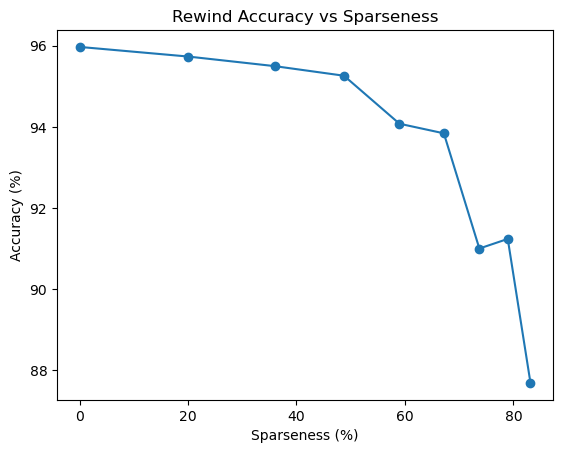

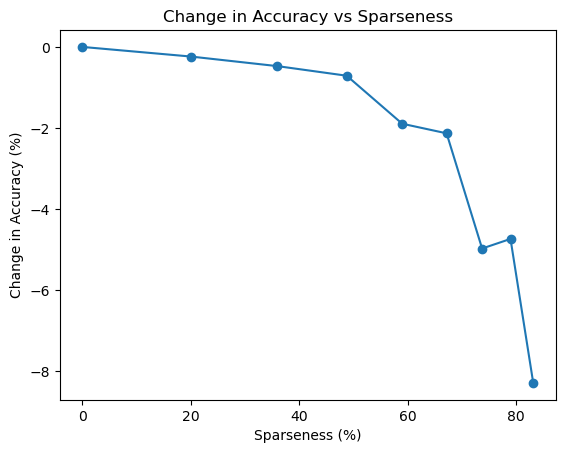

In [94]:
# calculate change from unpruned model
change_from_base = []
base_accuracy = final_test_accuracies[0]

for a in final_test_accuracies:
    change_from_base.append(a - base_accuracy)

plt.plot(sparse_percentages, final_test_accuracies, "o-")
#plt.plot(sparse_percentages, "d-")
plt.xlabel('Sparseness (%)')
plt.ylabel('Accuracy (%)')
plt.title('Rewind Accuracy vs Sparseness')
plt.show()

plt.plot(sparse_percentages, change_from_base, "o-")
#plt.plot(sparse_percentages, "d-")
plt.xlabel('Sparseness (%)')
plt.ylabel('Change in Accuracy (%)')
plt.title('Change in Accuracy vs Sparseness')
plt.show()

# 5. Room for Improvement
1. Generalize

One of the early goals discussed for this project was to write a generalizable script that could be run on any model to prune it via this iterative learning-rate rewinding. I think that could be done with a configuration file that outlines the necessary parameters of the original model (what model it was, learning rate, optimizer, datasets, etc.).

2. CUDA

I only spent a few hours early on trying different approaches to getting the CUDA Toolkit installed and working on my computer with an Nvidia GTX 1060, but ultimately gave up and ran everything in the CPU so I could start working. My understanding is that this would speed up the retraining process quite a bit. For the model used in this example, the training time was approximately 1 hour per 10 epochs. This was especially frustrating when windows installed an update and rebooted mid-run at two in the morning.

3. File Paths

The files paths throughout the program are absolute, rather than relative or parameters. This was what I started with and I did not get around to changing that. Relative or parameterized paths would make it significantly easier to get the script working on another computer, even without further generalization like in point 1.

4. prune_all_layer-weights

There are more elegant ways to iterate through model layers looking for prunable parameters. For example, it could be changed to prune any layer where requires_grad=True, and it could look for layer types that are containers and recursively search those rather than check for each container type explicitly.

5. Global Variables

I used a lot of global variables, which really bothers me from a style point of view. That would be straight-forward to fix, but time-consuming.

6. Number of Epochs

I mentioned it above, but I suspect that increasing the number of training epochs per iteration would increase the compression ratio for a given loss in accuracy. It would not take much work to modify this code to do that, but it would an order of magnitude more time to compute. I may take advantage of an unused server at work and try that.

7. General Machine Learning Knowledge

I learned quite a bit about working with and pruning neural networks, but I still know very little about the underlying theory or how they are built and trained. I suspect there are a number of questionable choices in the above code that reflect that for someone with better knowledge, but are invisible to me.